<a href="https://colab.research.google.com/github/pkansagra99/Work_Samples/blob/main/FMNIST_CV_(ELU%20%2B%20HE%20Initialization%20%2B%20Batch%20Norm%20%2B%20weight%20Decay).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'><b><font color ='pickle'>MLP Final Model</b></h1>

**Notebook Plan**
- (ELU + HE Initialization + Batch Norm + weight Decay)





# <Font color = 'pickle'>**Load Libraries/Install Software**

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Not running on CoLab


In [ ]:
# Install wandb and update it to the latest version
if 'google.colab' in str(get_ipython()):
    !pip install wandb --upgrade -q

In [ ]:
# mount google drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CyclicLR, OneCycleLR, StepLR

import numpy as np
import random

from datetime import datetime
from pathlib import Path
import sys
from types import SimpleNamespace

import wandb


In [ ]:
# Login to W&B
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# <Font color = 'pickle'>**Specify Project Folders**

In [ ]:
# This is the path where we will downlaod and save data
if 'google.colab' in str(get_ipython()):
  base_folder = Path('/content/drive/MyDrive/data')
else:
  base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data')

In [ ]:
data_folder = base_folder/'datasets/'
model_folder = base_folder/'models/dl_fall_2022/fmnist'
custom_functions = base_folder/'custom-functions'

In [ ]:
model_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
sys.path.append(str(custom_functions))

In [ ]:
sys.path

['/home/harpreet/Insync/google_drive_teaching/teaching_fall_2022/dl-fall-2022/Lecture_8_CNN_II',
 '/home/harpreet/mambaforge/lib/python39.zip',
 '/home/harpreet/mambaforge/lib/python3.9',
 '/home/harpreet/mambaforge/lib/python3.9/lib-dynload',
 '',
 '/home/harpreet/mambaforge/lib/python3.9/site-packages',
 '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions',
 '/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions']

# <Font color = 'pickle'>**Fashion-MNIST Dataset**

Fashion-MNIST dataset consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. Thus, train set contains 60000 images and test set 10000 images.

All the images are grayscale with dimensions 28 x 28.

Categories present in the dataset: <font color = 'indianred'>**t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot**</font>

Let us download the dataset using some built-in functions.

We will first convert the images in the dataset to pytorch tensors using torchvision.transforms and then normalize them.

Next, we will use torchvision.datasets for downloading the Fashion-MNIST datasets and apply transform that we defines earlier.

- `trainset` conains the training data
- `testset` contains the testing data

## <Font color = 'pickle'>**Train and Test Dataset**


In [ ]:
# Transform to convert images to pytorch tensors
trans1 = transforms.ToTensor()

# Transform to normalize the data
# The mean and std are based on train subset which we will create below
trans2 = transforms.Normalize((0.2857,), (0.3528))
trans = transforms.Compose([trans1, trans2])

# Download the training_validation data (we will create two subsets - trainset and valset frpm this)
train_val_set = torchvision.datasets.FashionMNIST(root = data_folder,
                                             train = True,
                                             transform = trans,
                                             download = True)

# Download the testing data
testset = torchvision.datasets.FashionMNIST(root = data_folder,
                                            train = False,
                                            transform = trans,
                                            download = True)

## <Font color = 'pickle'>**Split train set to train/validation set**

In [ ]:
def split_dataset(base_dataset, fraction, seed):
    split_a_size = int(fraction * len(base_dataset))
    split_b_size = len(base_dataset) - split_a_size
    return torch.utils.data.random_split(base_dataset, [split_a_size, split_b_size], generator=torch.Generator().manual_seed(seed)
    )

In [ ]:
trainset, validset = split_dataset(train_val_set, 0.8, 42)

In [ ]:
# Since the transforms are not applied, we will manually first divide by 255
# we will then get the mean and std dev
# the images are still in mumpy with the shape (number of images, H, W, Channels)
# Since we need mean, std dev
train_data = train_val_set.data[trainset.indices]/255
train_data.shape
print(train_data.mean(axis = (0,1,2)))
print(train_data.std(axis = (0,1,2)))

tensor(0.2857)
tensor(0.3528)


## <Font color = 'pickle'>**Small Sample**

In [ ]:
# n sample points
train_sample_size = int(len(trainset)/500)
valid_sample_size = int(len(validset)/100)

# Getting n random indices
train_subset_indices = random.sample(range(0, len(trainset)), train_sample_size)
valid_subset_indices = random.sample(range(0, len(testset)), valid_sample_size)

# Getting subset of dataset
train_subset = torch.utils.data.Subset(trainset, train_subset_indices)
valid_subset = torch.utils.data.Subset(validset, valid_subset_indices)

## <Font color = 'pickle'>**Check inputs**

In [ ]:
print(type(trainset), type(trainset.dataset), type(trainset.indices), sep ='\n')

<class 'torch.utils.data.dataset.Subset'>
<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'list'>


In [ ]:
trainset.indices[0:5]

[37542, 43087, 2992, 25810, 39634]

In [ ]:
print(len(trainset), len(trainset.dataset), len(trainset.indices), sep ='\n')

48000
60000
48000


In [ ]:
# Shape of training data
len(trainset.indices), len(validset.indices)

(48000, 12000)

In [ ]:
print(train_val_set.data[trainset.indices].shape)
print(trainset.dataset.data[trainset.indices].shape)

torch.Size([48000, 28, 28])
torch.Size([48000, 28, 28])


In [ ]:
train_val_set.data[validset.indices].shape

torch.Size([12000, 28, 28])

In [ ]:
# Shape of testing data
testset.data.shape

torch.Size([10000, 28, 28])

In [ ]:
# check the max value of inputs - the transformation are not yet applied.
# the transofrmation are applied iteratively on batches
# when we craete batch by iterating over dataloader
train_val_set.data[trainset.indices].max()

tensor(255, dtype=torch.uint8)

In [ ]:
# check the min value of inputs
train_val_set.data[trainset.indices].min()

tensor(0, dtype=torch.uint8)

## <Font color = 'pickle'>**Check Labels**

In [ ]:
# check target values for train set
train_val_set.targets[trainset.indices].shape

torch.Size([48000])

In [ ]:
# Unique Target values
train_val_set.targets[trainset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
train_val_set.targets[validset.indices].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
testset.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## <Font color = 'pickle'>**Check Transformations**

- Check if transformation are working correctly.
- The transformations are applied at the time of calling dataloader

In [ ]:
# Initializing the batch size
batch_size = 32

check_loader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

In [ ]:
# check number of batches
len(check_loader)

750

In [ ]:
# check total training examples
len(check_loader.dataset)

48000

In [ ]:
# check imputs and outputs
for input, target in check_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmin input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nstd input value  :{input.std()}')
  print(f'\nshape of targets is :{target.shape}')
  print(f'\ninputs  :{input[0, 0, 5:10, 5:10]}')

  break

shape of inputs is :torch.Size([64, 1, 28, 28])

max input value  :2.0246598720550537

min input value  :-0.8098071813583374

mean input value  :0.011697734706103802

std input value  :0.9971328973770142

shape of targets is :torch.Size([64])

inputs  :tensor([[-0.8098, -0.8098, -0.8098, -0.7876, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.7987, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.8098, -0.8098],
        [-0.8098, -0.8098, -0.8098, -0.7876, -0.8098]])


# <Font color = 'pickle'>**Visualize the Data**

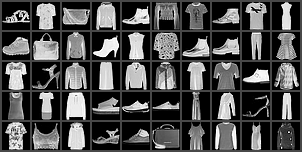

In [ ]:
# Get some random training images
dataiter = iter(check_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 10)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
images.image

In [ ]:
# Define the values for classes
classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# <font color = 'pickle'> **Functions to implement Softmax**

Now, we will start implementing our Softmax Regression Model from scratch.

We will now create following functions:

- **Model**
- **Loss Function**
- **One Hot Encoding**
- **Training Loop for 1 epoch**
- **Validation Loop for 1 epoch**
- **Model Training** - repeat the training and validation loops for given number of epochs
- **Function to get the accuracy given the model**

## <Font color = 'pickle'>**Custom Deep NN**

In [ ]:
class CustomDeepNetwork(nn.Module):
  def __init__(self,  input_dim, output_dim, h_sizes, dprob, non_linearity, batch_norm):

    super().__init__()
    self.input_dim = input_dim
    self.h_sizes = h_sizes # list of hidden sizes
    self.non_linearity = non_linearity
    self.batch_norm = batch_norm
    self.dprob = dprob # list of dropout probabilities
    self.output_dim = output_dim

    # Initialize hidden layers
    model_layers = [nn.Flatten()]

    # hidden layers
    for i, hidden_size in enumerate(self.h_sizes):
      model_layers.append(nn.Linear(input_dim, hidden_size))
      model_layers.append(self.non_linearity)
      model_layers.append(nn.Dropout(p=dprob[i]))

      if self.batch_norm:
        model_layers.append(nn.BatchNorm1d(hidden_size, momentum=0.9))

      input_dim = hidden_size

    # output layer
    model_layers.append(nn.Linear(self.h_sizes[-1], self.output_dim))

    self.module_list = nn.ModuleList(model_layers)


  def forward(self, x):
    for layer in self.module_list:
      x = layer(x)

    # we are not using softmax function in the forward passs
    # nn.crossentropy loss (which we will use to define our loss) combines  nn.LogSoftmax() and nn.NLLLoss() in one single class
    return x

## <Font color = 'pickle'>**Function for Training  Loops**

**Model Training** involves five steps:

- Step 0: Randomly initialize parameters / weights
- Step 1: Compute model's predictions - forward pass
- Step 2: Compute loss
- Step 3: Compute the gradients
- Step 4: Update the parameters
- Step 5: Repeat steps 1 - 4

Model training is repeating this process over and over, for many **epochs**.

We will specify number of ***epochs*** and during each epoch we will iterate over the complete dataset and will keep on updating the parameters.

***Learning rate*** and ***epochs*** are known as hyperparameters. We have to adjust the values of these two based on validation dataset.

We will now create functions for step 1 to 4.

In [ ]:
def train(train_loader, loss_function, model, optimizer, grad_clipping, max_norm, log_batch, log_interval):

  # Training Loop

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_train

  # Initialize train_loss at the he start of the epoch
  running_train_loss = 0
  running_train_correct = 0

  # put the model in training mode

  model.train()
  # Iterate on batches from the dataset using train_loader
  for input_, targets in train_loader:

    # move inputs and outputs to GPUs
    input_ = input_.to(device)
    targets = targets.to(device)


    # Step 1: Forward Pass: Compute model's predictions
    output = model(input_)

    # Step 2: Compute loss
    loss = loss_function(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    batch_ct_train += 1

    # Step 3: Backward pass -Compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    if grad_clipping:
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm, norm_type=2)

    # Step 4: Update the parameters
    optimizer.step()

    # Add train loss of a batch
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct

    # log batch loss and accuracy
    if log_batch:
      if ((batch_ct_train + 1) % log_interval) == 0:
        wandb.log({f"Train Batch Loss  :": loss})
        wandb.log({f"Train Batch Acc :": correct/len(targets)})


  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)


  return train_loss, train_acc

## <Font color = 'pickle'>**Function for Validation Loops**


In [ ]:
def validate(valid_loader, loss_function, model, log_batch, log_interval):

  # initilalize variables as global
  # these counts will be updated every epoch
  global batch_ct_valid

  # Validation/Test loop
  # Initialize valid_loss at the he strat of the epoch
  running_val_loss = 0
  running_val_correct = 0

  # put the model in evaluation mode
  model.eval()

  with torch.no_grad():
    for input_,targets in valid_loader:

      # move inputs and outputs to GPUs
      input_ = input_.to(device)
      targets = targets.to(device)

      # Step 1: Forward Pass: Compute model's predictions
      output = model(input_)

      # Step 2: Compute loss
      loss = loss_function(output, targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      batch_ct_valid += 1

      # Add val loss of a batch
      running_val_loss += loss.item()

      # Add correct count for each batch
      running_val_correct += correct

      # log batch loss and accuracy
      if log_batch:
        if ((batch_ct_valid + 1) % log_interval) == 0:
          wandb.log({f"Valid Batch Loss  :": loss})
          wandb.log({f"Valid Batch Accuracy :": correct/len(targets)})

    # Calculate mean val loss for the whole dataset for a particular epoch
    val_loss = running_val_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    val_acc = running_val_correct/len(valid_loader.dataset)

    # scheduler step
    scheduler.step(val_loss)
    # scheduler.step()

  return val_loss, val_acc

## <Font color = 'pickle'>**Function for Model Training**
    
We will now create a function for step 5 of model training


In [ ]:
def train_loop(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience, early_stopping,
               file_model, save_best_model):

  """
  Function for training the model and plotting the graph for train & validation loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and validation loss for each epoch.
  """

  # Create lists to store train and val loss at each epoch
  train_loss_history = []
  valid_loss_history = []
  train_acc_history = []
  valid_acc_history = []

  # initialize variables for early stopping

  delta = 0
  best_score = None
  valid_loss_min = np.Inf
  counter_early_stop=0
  early_stop=False

  # Iterate for the given number of epochs
  # Step 5: Repeat steps 1 - 4

  for epoch in range(epochs):

    t0 = datetime.now()

    # Get train loss and accuracy for one epoch
    train_loss, train_acc = train(train_loader, loss_function, model, optimizer,
                                  wandb.config.grad_clipping, wandb.config.max_norm,
                                  wandb.config.log_batch, wandb.config.log_interval)
    valid_loss, valid_acc   = validate(valid_loader, loss_function, model, wandb.config.log_batch, wandb.config.log_interval)

    dt = datetime.now() - t0

    # Save history of the Losses and accuracy
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)

    # Log the train and valid loss to wandb
    wandb.log({f"Train Loss :": train_loss, "epoch": epoch})
    wandb.log({f"Train Acc :": train_acc, "epoch": epoch})

    wandb.log({f"Valid Loss :": valid_loss, "epoch": epoch})
    wandb.log({f"Valid Acc :": valid_acc, "epoch": epoch})

    if early_stopping:
      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        counter_early_stop += 1
        print(f'Early stoping counter: {counter_early_stop} out of {patience}')
        if counter_early_stop > patience:
          early_stop = True


      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        counter_early_stop=0
        valid_loss_min = valid_loss

      if early_stop:
        print('Early Stopping')
        break

    elif save_best_model:

      score = -valid_loss
      if best_score is None:
        best_score=score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

      elif score < best_score + delta:
        print(f'Validation loss has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model...')

      else:
        best_score = score
        print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), file_model)
        valid_loss_min = valid_loss

    else:
        torch.save(model.state_dict(), file_model)

    # Print the train loss and accuracy for given number of epochs, batch size and number of samples
    print(f'Epoch : {epoch+1} / {epochs}')
    print(f'Time to complete {epoch+1} is {dt}')
    print(f'Learning rate: {scheduler._last_lr[0]}')
    print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
    print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
    print()
    torch.cuda.empty_cache()

  return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

## <Font color = 'pickle'>**Function for Accuracy and Predictions**

Now we have final values for weights and bias after training the model. We will use these values to make predictions on the test dataset.

In [ ]:
def get_acc_pred(data_loader, model, device):

  """
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Prections and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  # put the model in evaluation mode
  model.eval()

  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:

      # move inputs and outputs to GPUs

      input_ = input_.to(device)
      targets = targets.to(device)

      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, prediction))

      # Add the actual labels to the array
      y = torch.cat((y, targets))

  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, acc

# <Font color = 'pickle'>**Meta Data**

In [ ]:
hyperparameters = SimpleNamespace(
    epochs = 50,
    input_dim = 784,
    output_dim = 10,
    h_sizes = [300] * 5,
    dprob = [0] * 5,
    non_linearity = nn.ELU(),
    batch_norm = True,
    batch_size=128,
    learning_rate=0.05,
    dataset="FashionMNIST",
    architecture="Deep_NN",
    log_interval = 25,
    log_batch = True,
    file_model = model_folder/'final_fmnist.pt',
    grad_clipping = True,
    max_norm = 1,
    momentum = 0.9,
    patience = 10,
    early_stopping = True,
    scheduler_factor = 0.5,
    scheduler_patience = 0,
    weight_decay = 0.001,
    save_best_model = True,
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    )

# <Font color = 'pickle'>**Data Loaders, Loss Function, Optimizer**

In [ ]:
# Initialize a new project
wandb.init(name = "exp1", project = 'dl22_reg' , config = hyperparameters)

Train Batch Acc :,▃▁▅▃▆▆▄▅▅▆▆▆▆█▄
Train Batch Loss :,▆█▃▆▄▃▃▆▂▃▃▂▃▁▅
Valid Batch Accuracy :,▁
Valid Batch Loss :,▁
Train Batch Acc :,0.79688
Train Batch Loss :,0.5305
Valid Batch Accuracy :,0.85938
Valid Batch Loss :,0.52499


In [ ]:
wandb.config = hyperparameters
wandb.config

namespace(epochs=50,
          input_dim=784,
          output_dim=10,
          h_sizes=[300, 300, 300, 300, 300],
          dprob=[0, 0, 0, 0, 0],
          non_linearity=ELU(alpha=1.0),
          batch_norm=True,
          batch_size=128,
          learning_rate=0.05,
          dataset='FashionMNIST',
          architecture='Deep_NN',
          log_interval=25,
          log_batch=True,
          file_model=PosixPath('/home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2022/fmnist/final_fmnist.pt'),
          grad_clipping=True,
          max_norm=1,
          momentum=0.9,
          patience=10,
          early_stopping=True,
          scheduler_factor=0.5,
          scheduler_patience=0,
          weight_decay=0.001,
          save_best_model=True,
          device=device(type='cuda', index=0))

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=wandb.config.batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=wandb.config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=wandb.config.batch_size,   shuffle = False)

# model
model = CustomDeepNetwork(wandb.config.input_dim, wandb.config.output_dim, wandb.config.h_sizes,
                          wandb.config.dprob, wandb.config.non_linearity, wandb.config.batch_norm)

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
def init_weights(layer):
  if type(layer) == nn.Linear:
    torch.nn.init.kaiming_normal_(layer.weight)
    torch.nn.init.zeros_(layer.bias)

model.to(wandb.config.device)
model.apply(init_weights)

# loss_function
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),
                            lr = wandb.config.learning_rate,
                            momentum = wandb.config.momentum,
                            weight_decay = wandb.config.weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= wandb.config.scheduler_factor,
                              patience=wandb.config.scheduler_patience, verbose=True)

#scheduler = StepLR(optimizer, gamma=0.4,step_size=1, verbose=True)

# <Font color = 'pickle'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
i = 0
for input_, targets in train_loader:

  # move inputs and outputs to GPUs
  input_ = input_.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input_)
  loss = loss_function(output, targets)
  print(f'Actual loss: {loss}')
  i += 1

  if i >2:
    break


print(f'Expected Theoretical loss: {np.log(10)}')

Actual loss: 3.825993299484253
Actual loss: 4.0214385986328125
Actual loss: 4.056970596313477
Expected Theoretical loss: 2.302585092994046


# <Font color = 'pickle'>**Training Model**

In [ ]:
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# See live graphs in the notebook.
#%%wandb
batch_ct_train, batch_ct_valid = 0, 0
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_loop(train_loader,
                                                                                          valid_loader,
                                                                                          model,
                                                                                          optimizer,
                                                                                          loss_function,
                                                                                          wandb.config.epochs,
                                                                                          wandb.config.device,
                                                                                          wandb.config.patience,
                                                                                          wandb.config.early_stopping,
                                                                                          wandb.config.file_model,
                                                                                          wandb.config.save_best_model
                                                                                          )

Validation loss has decreased (inf --> 0.432644). Saving Model...
Epoch : 1 / 50
Time to complete 1 is 0:00:08.214409
Learning rate: 0.05
Train Loss:  0.5104 | Train Accuracy:  82.0375%
Valid Loss:  0.4326 | Valid Accuracy:  85.2750%

Validation loss has decreased (0.432644 --> 0.360886). Saving model...
Epoch : 2 / 50
Time to complete 2 is 0:00:08.056055
Learning rate: 0.05
Train Loss:  0.3722 | Train Accuracy:  86.3042%
Valid Loss:  0.3609 | Valid Accuracy:  86.5667%

Validation loss has decreased (0.360886 --> 0.347501). Saving model...
Epoch : 3 / 50
Time to complete 3 is 0:00:07.978682
Learning rate: 0.05
Train Loss:  0.3381 | Train Accuracy:  87.5583%
Valid Loss:  0.3475 | Valid Accuracy:  87.1417%

Epoch 00004: reducing learning rate of group 0 to 2.5000e-02.
Early stoping counter: 1 out of 10
Epoch : 4 / 50
Time to complete 4 is 0:00:07.747078
Learning rate: 0.025
Train Loss:  0.3274 | Train Accuracy:  87.9542%
Valid Loss:  0.3586 | Valid Accuracy:  87.3750%

Validation loss ha

# <Font color = 'pickle'>**Get Accuracy, Predictions**

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# model_saved = shallow_nn_seq(wandb.config.input_dim, wandb.config.output_dim, wandb.config.hidden_dim1, bias=True)
#model_saved = DeepNetwork(wandb.config.input_dim, wandb.config.output_dim, wandb.config.hidden_dim1, wandb.config.hidden_dim2,
#                   wandb.config.hidden_dim3, wandb.config.hidden_dim4)
model_saved= CustomDeepNetwork(wandb.config.input_dim, wandb.config.output_dim, wandb.config.h_sizes,
                          wandb.config.dprob, wandb.config.non_linearity, wandb.config.batch_norm)
model_saved.to(device)
model_saved.load_state_dict(torch.load(wandb.config.file_model))

<All keys matched successfully>

In [ ]:
# Get the prediction and accuracy for the test dataseta
predictions_test, acc_test = get_acc_pred(test_loader, model_saved, device)
predictions_train, acc_train = get_acc_pred(train_loader, model_saved, device)
predictions_valid, acc_valid = get_acc_pred(valid_loader, model_saved, device)

In [ ]:
# Print Test Accuracy
print('Test accuracy', acc_test * 100)
print('Train accuracy', acc_train * 100)
print('Valid accuracy', acc_valid * 100)

Test accuracy tensor(89.0200, device='cuda:0')
Train accuracy tensor(95.2146, device='cuda:0')
Valid accuracy tensor(89.8083, device='cuda:0')


In [ ]:
wandb.log({'Best_test_Acc': acc_test})
wandb.log({'Best_train_Acc': acc_train})
wandb.log({'Best_valid_Acc': acc_valid})

# <Font color = 'pickle'>**Confusion Matrix for Test Data**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:
# Get an array containing actual labels
testing_labels = np.array(testset.targets)

In [ ]:
np.unique(testing_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Log a confusion matrix to W&B
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs = None,
                        y_true = testing_labels,
                        preds = predictions_test.to('cpu').numpy(),
                        class_names = classes)})


In [ ]:
wandb.finish()

Best_test_Acc,▁
Best_train_Acc,▁
Best_valid_Acc,▁
Train Acc :,▁▃▄▄▅▅▆▆▇▇▇▇▇█████████████
Train Batch Acc :,▁▄▃▆▄▃▄▇▇▅▄▆▆▇▇▆▆▆▆▇█▇▇▇▇▆▆▇▇▆▇▇██▆▇▇▇▇▇
Train Batch Loss :,█▅▅▃▅▅▄▂▂▃▄▃▃▂▁▂▃▂▃▂▁▂▂▂▁▂▃▂▂▂▂▁▁▁▂▂▁▁▁▂
Train Loss :,█▅▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Acc :,▁▃▄▄▆▅▆▅▇▇▇▇▇▇█▇██████▇▇█▇
Valid Batch Accuracy :,▂▁▆▂▁▃▂▁▃▂▇▄▂▄▅▄▆▃▇▃▂▃▆▅▃▆▅▅▂▃▇▄█▄▄▃▂▄▅▃
Valid Batch Loss :,█▇▃▄▆▅▅▇▄▆▃▄▅▅▄▅▃▄▃▅▆▄▃▄▆▃▄▄▇▆▃▄▁▅▅▆▅▄▃▄
Valid Loss :,█▄▄▄▂▃▂▃▂▁▂▁▂▂▁▂▁▁▁▂▁▂▂▂▂▂
